# Capstone proposal by Andreas Jud

# Deduplication of Swissbib raw data

**Author** Andreas Jud</p>
**Date** 03-JAN-2020

**Task** The details are outlined in the **[Proposal](./01_Proposal.pdf)** unit on the platform - you should address all points from those instructions with as many markdown/code cells as needed. This should include code, observations, discussions and the planned steps.

## Introduction

[Swissbib](https://www.swissbib.ch/) is the online catalogue of all Swiss university libraries, the Swiss National Library, numerous cantonal libraries, and further institutions. It provides a fast, simple, and extensive access to scientific publications in Switzerland [[1](#swissbib)].

## 1) The problem

Swissbib receives electronic catalogue data of Swiss library network databases with more than 800 institutions behind. The data is processed with dayly delta loads. The Swissbib platform merges the received data records from all sources with the data records received with earlier loads. After that, the platform processes all records into its search engine, where users can search for bibliographic entities. The key step in this merging process is to identify duplicate physical entities out of the original raw data with the goal of combining their records, generating a set of unique records as the basis for indexing in the search engine. This deduplication process has to handle records with minor differences referring to copies of the same physical entities in two different libraries.

Swissbib's data processing platform CBS transforms data from its sources into a data format called [pica](https://format.gbv.de/pica), see Data Preprocessing in [figure 1](#f_basic_data_flow), and deduplicates these indexed records with an engine written in programming language C and configured with pica, see Clustering in [figure 1](#f_basic_data_flow). The identification of duplicate records in the data records is done with the help of a set of predefined attributes. The records to be deduplicated are compared in these attributes with a sophisticated logic. Goal of the capstone project is to replace Swissbib's established deduplication logic with the help of Machine Learning.

## 2) The data

### (a) Clear overview of your data

The Swissbib platform loads raw data out of its sources in dayly delta loads and stores all records in a [Sybase](https://en.wikipedia.org/wiki/Sybase) database, see [figure 1](#f_basic_data_flow). After having preprocessed all data records from its sources, a module of the CBS platform indexes the raw data into a [b-tree file system](https://en.wikipedia.org/wiki/Btrfs). This indexed data is then forwarded by a clustering process to an index of the search engine. This data is in a deduplicated state and is available online [[1](#swissbib)] for end users to search for catalogue records and its physical entities behind.

<center>
    <b>Figure 1</b><a id='f_basic_data_flow'></a> Basic data flow for processing Swissbib's raw data into its search engine.
    <img src="./documentation/dataflow_basic.png" style="width: 600px;"/></p>
</center>

The Swissbib platform holds records of a total number of more than 31 million distinct entities out of 28 source databases [[2](#meeting_20191015)]. The raw data of the sources is deduplicated in a clustering module of the CBS platform, see [figure 1](#f_basic_data_flow), in order to identify the set of records describing distinct physical entities. The data extract below [[2](#meeting_20191015)] illustrates the amount of data being held and processed by the platform. In the data extract shown, a maximum threshold of 17 records per cluster is considered to be a reliable amount [[2](#meeting_20191015)].

In [1]:
import pandas as pd

df = pd.read_csv('./data/cluster_sizes.csv', sep='\s+',
                 header=None, names=['number_of_clusters', 'records_in_cluster'])

cluster_size_threshold = 17
df.where(df.records_in_cluster <= cluster_size_threshold).dropna().astype(int)

,number_of_clusters,records_in_cluster
0,3369004,2
1,1212276,3
2,545500,4
3,241145,5
4,112948,6
5,60816,7
6,35637,8
7,21578,9
8,13336,10
9,7932,11


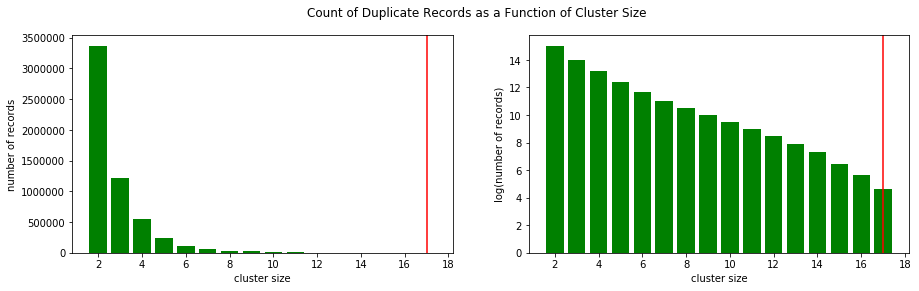

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].bar(df['records_in_cluster'].where(df.records_in_cluster <= cluster_size_threshold).dropna().astype(int),
            df['number_of_clusters'].where(df.records_in_cluster <= cluster_size_threshold).dropna().astype(int)
        ,
        color='green')
axs[0].axvline(x=cluster_size_threshold, color='red') # Threshold
axs[0].set_xlabel('cluster size')
axs[0].set_ylabel('number of records')
axs[1].bar(df['records_in_cluster'].where(df.records_in_cluster <= cluster_size_threshold).dropna().astype(int),
        np.log(
            df['number_of_clusters'].where(df.records_in_cluster <= cluster_size_threshold).dropna().astype(int)
        )
        ,
        color='green')
axs[1].axvline(x=cluster_size_threshold, color='red') # Threshold
axs[1].set_xlabel('cluster size')
axs[1].set_ylabel('log(number of records)')
fig.suptitle('Count of Duplicate Records as a Function of Cluster Size')
plt.show()

The amount of processed records of the Swissbib platform as of date of [[2](#meeting_20191015)] sums up to the structure below.

In [3]:
number_of_uniques = 25479651
number_of_masters = df.number_of_clusters.where(df.records_in_cluster <= cluster_size_threshold).sum().astype(int)
number_of_slaves = (df.number_of_clusters
#                    .where(df.records_in_cluster <= cluster_size_threshold)
                    *(df.records_in_cluster
#                      .where(df.records_in_cluster <= cluster_size_threshold)-1
                     )).sum().astype(int)

print('Count of records ...')
print('- original\t{:,} (100%)'.format(number_of_uniques+number_of_masters+number_of_slaves))
print('... and thereof ...')
print('- duplicates\t{:,} ({:.1f}%)'.format(number_of_slaves,
                                        100*number_of_slaves/(number_of_uniques+number_of_masters+number_of_slaves)))
print('- uniques\t{:,} ({:.1f}%)'.format(number_of_uniques,
                             100*number_of_uniques/(number_of_uniques+number_of_masters+number_of_slaves)))
print('- clusters\t{:,} ({:.1f}%)'.format(number_of_masters,
                             100*number_of_masters/(number_of_uniques+number_of_masters+number_of_slaves)))
print('\n- fully deduplicated\t{:,} ({:.1f}%)'.format(number_of_uniques+number_of_masters,
                                     100*(number_of_uniques+number_of_masters)/(number_of_uniques+number_of_masters+number_of_slaves)))
print('\t\t\t==========')

Count of records ...
- original	46,816,243 (100%)
... and thereof ...
- duplicates	15,706,550 (33.5%)
- uniques	25,479,651 (54.4%)
- clusters	5,630,042 (12.0%)

- fully deduplicated	31,109,693 (66.5%)


With the [sru interface](https://en.wikipedia.org/wiki/Search/Retrieve_via_URL) [[3](#swissbib_sru)], the Swissbib project offers a protocol to acces its processed and indexed data via URL. The search engine can be queried via this interface to deliver masses of records in an [xml](https://www.w3.org/XML/) or a [json](https://www.json.org/json-en.html) format responding to the sent request. The data via [[3](#swissbib_sru)] partially underlies open acces according to the [Creative Commons license](https://en.wikipedia.org/wiki/Creative_Commons_license) of CC0 [[4](#cc0)].

Some parts of the data of [[3](#swissbib_sru)] is under protection, though, e.g. records enriched with data from [worldcat](https://www.worldcat.org/). These parts of the data will be filtered out of the data to be processed during the capstone project. This will be guaranteed by a specific preprocessing of the data for the capstone project, compare orange coloured data path of [figure 1](#f_basic_data_flow) and description below. The search engine [[5](#swissbib_cc0)] offers access to the fully open data, exclusively.

A data record provided by Swissbib consists of a set of data elements filled with their values. The structure and contents of the data records are based on [MARC 21 Format for Bibliographic Data](https://en.wikipedia.org/wiki/MARC_standards), [[6](#marc21)]. Within the scope of the capstone project, the data records will be narrowed down to a reduced set of the available attributes of the MARC 21 standard. The reduction focusses on the attributes that are used for deduplication with the already implemented logic. This reduction is done in a separate data export with a scala implementation, developped by a Swissbib project member specifically for the capstone project [[7](#scala_repo)], see orange coloured part of [figure 1](#f_basic_data_flow). The resulting output of the data preprocessing by Swissbib will be one or more files in a json format. These files will be read into Python for explaratory data analysis (EDA) and manipulation in the scope of the capstone project.

The list of attributes that will be used as a starting point for the capstone project is documented in [[8](#feature_deduplication_wiki)]. Some additional attributes out of the MARC 21 attribute definition may be identified and added optionally during the project. This option can be taken if additional attributes help to enhance the deduplication process.

The existing conventional deduplication implementation searches for duplicate records in the raw data. This is done with a sophisticated comparison logic of the above mentioned attributes. If two or more records are found to describe the same entity, one of the records is identified as the lead record. Afterwards, all of the identified duplicate records are united in a single record. This record is called _master_. The original records become _slaves_ of the master record. Eventually missing or differing data fields are consolidated into the master record. This process is sketched in [figure 2](#f_master_slaves).

<center>
    <b>Figure 2</b><a id='f_master_slaves'></a> Master generation out of a series of slaves.
    <img src="./documentation/master_slaves.png" style="width: 600px;"/></p>
</center>

The Swissbib project team holds a set of pre-defined records they use for testing purposes of their deduplication implementation. This set of records is called the _goldstandard_ and will be used as training set during the machine learning process.

Swissbib's goldstandard data comes along in three json files. The biggest file $\texttt{slave.json}$ holds all test records in their original form. This basic file is split into two files during the deduplication process. One of the two generated files is called $\texttt{master.json}$ which holds all master records and the other one is called $\texttt{unique.json}$ and holds all unique records out of the origin. The counts of the records in each file are calculated below.

In [4]:
import json as js

records_masters, records_slaves, records_uniques = [], [], []

for line in open('./daten_goldstandard/master.json', 'r'):
    records_masters.append(js.loads(line))
for line in open('./daten_goldstandard/slave.json', 'r'):
    records_slaves.append(js.loads(line))
for line in open('./daten_goldstandard/unique.json', 'r'):
    records_uniques.append(js.loads(line))

print('Count of records in file ...')
print('- slave\t', len(records_slaves))
print('- master', len(records_masters))
print('- unique', len(records_uniques))

Count of records in file ...
- slave	 435
- master 159
- unique 596


For the machine training and testing process, pairs of records will be generated, see below. Each pair of the goldstandard will be marked whether it is a pair of duplicates or of uniques. The amount of available records for training and testing out of the goldstandard is calculated with $\frac{1}{2}N\left(N-1\right)$. the following total number is determined for the goldstandard data set.

In [5]:
print('{:,}'.format(int(len(records_slaves)*(len(records_slaves)-1)/2)))

94,395


### (b) Plan to manage and process the data

The capstone project will start with the analysis of exported data by the orange data extract of [figure 1](#f_basic_data_flow). Goal will be to understand the data and the relationships in its attributes. The data comes along with substantial information in form of strings, e.g. in title and person, see below. Besides string manipulations, the exploratory data analysis will address handling of missing values and decide on actions to be taken for data cleaning.

A general data matching process is described in [[9](#data_matching)], see [figure 3](#f_data_matching_process). Swissbib's CBS platform has implemented this process.

<center>
    <b>Figure 3</b><a id='f_data_matching_process'></a> General data matching process [9].
    <img src="./documentation/datamatching_process.png" style="width: 400px;"/></p>
</center>

A data preprocessing step will be implemented in the beginning of the capstone project. The data will be manipulated in this step with the goal of generating a set of feature attributes for the machine learning process of deduplication. The features are to support the machine learning and the final deduplication process.

After the data preprocessing step in the general data matching process shown in [figure 3](#f_data_matching_process), the indexing of the data is a central step in preparing the data for record pair comparison [[9](#data_matching)]. During indexing, the full data set is split into blocks that hold records of similar entities. This splitting is called blocking [[9](#data_matching)] and the resulting blocks are called preclusters. Preclusters are the starting point for explicit record comparison in the deduplication process, see [figure 4](#f_clustering). The indexing step is crucial in that a minimal size of the preclusters reduces the processing time of the record pair comparison.

<center>
    <b>Figure 4</b><a id='f_clustering'></a> Blocking and clustering of full data.
    <img src="./documentation/clustering.png" style="width: 500px;"/></p>
</center>

The indexing and preclustering is done today by the CBS platform, see [figure 1](#f_basic_data_flow). The Swissbib project team plans to replace this indexing step with a new platform, see section 4c) below. The preclustering is outside of the scope of the capstone project.

After indexing, the record comparison is done pairwise for all records in each precluster, see [figure 3](#f_data_matching_process). In the record pair comparison step, the predefined attributes of two records are compared and a distance between them is derived. This step is the starting point of the central part of machine learning of the capstone project as the set of features to be used for model training will be specifically defined, see below. The data processing of the capstone project ends with the identification of the specific features for the machine lerning process and the definition of the distance metrics for each attribute, see below.

## 3) Exploratory data analysis (EDA)

Below, a sample data set of Swissbib's data extract is shown.

In [6]:
df_s = pd.DataFrame(records_slaves)

# Extend display to number of columns of DataFrame
pd.options.display.max_columns = len(df_s.columns)

df_s.head(10)

,035liste,century,coordinate,corporate,decade,docid,doi,edition,exactDate,format,isbn,ismn,musicid,pages,part,person,pubinit,pubword,pubyear,scale,ttlfull,ttlpart,volumes
0,"[(OCoLC)731635279, (ABN)000539983]",2009,[],{},2009,000311049,[],,2009,[BK020000],[978-3-15-020008-7],[],,[600 S.],[20008],{'100': ['AustenJane1775-1817(DE-588)118505173...,[Reclam jun.],[Reclam jun.],2009,,"{'245': ['Emma', 'Roman']}","{'245': ['Emma', 'Roman']}",[600 S.]
1,"[(OCoLC)808324878, (ABN)000155059]",2000,[],"{'710': ['Metropolitan Opera Orchestra', 'Metr...",2000,00130724X,[],,2000,[VM010300],[],[],,"[1 DVD-Video, DVD Region 0, 169 Min., farb.]",[],"{'100': ['LevineJamesDir.'], '700': ['MozartWo...",[Deutsche Grammophon],[Deutsche Grammophon],2000,,"{'245': ['Die Zauberflöte', 'Oper in zwei Aufz...","{'245': ['Die Zauberflöte', 'Oper in zwei Aufz...","[1 DVD-Video, DVD Region 0, 169 Min., farb.]"
2,"[(OCoLC)231772550, (ABN)000096920]",1999,[],{},1999,001817272,[],,1999,[BK020000],[3-495-47879-5],[],,[316 S.],[],"{'100': ['FluryAndreas'], '245c': ['Andreas Fl...",[Alber],[Alber],1999,,"{'245': ['Der moralische Status der Tiere', 'H...","{'245': ['Der moralische Status der Tiere', 'H...",[316 S.]
3,"[(OCoLC)887157168, (ABN)000223912]",uuuu,[],{},uuuu,00236865X,[],,uuuuuuuu,[BK020000],[],[],,[412 S.],[],"{'100': ['MozartWolfgang Amadeus'], '245c': ['']}",[Ernst Eulenburg],[Ernst Eulenburg],uuuuuuuu,,{'245': ['Die Zauberflöte']},{'245': ['Die Zauberflöte']},[412 S.]
4,"[(OCoLC)887324690, (ABN)000548154]",2008,[],{},2008,00351031X,[],,2008,[BK020000],[978-1-4058-8214-9],[],,[64 S.],[],{'100': ['AustenJane1775-1817(DE-588)118505173...,[Pearson Education],[Pearson Education],2008,,{'245': ['Emma']},{'245': ['Emma']},[64 S.]
5,"[(OCoLC)180154028, (ABN)000308006]",2007,[],{},2007,003517837,[],1. Aufl,2007,[BK020000],"[978-3-7815-1531-4, 3-7815-1531-1]",[],,[304 S.],[],"{'100': [], '700': ['Gläser-ZikudaMichaela'], ...",[Klinkhardt],[Klinkhardt],2007,,"{'245': ['Lernprozesse dokumentieren, reflekti...","{'245': ['Lernprozesse dokumentieren, reflekti...",[304 S.]
6,"[(OCoLC)605622457, (ABN)000234417]",1988,[],{},1988,003555208,[],,1988,[MU040100],[],[],Teldec,[2 Compact Discs in Box],[],"{'100': ['MozartWolfgang Amadeus'], '700': ['H...",[Teldec],[Teldec],1988,,{'245': ['Die Zauberflöte']},{'245': ['Die Zauberflöte']},[2 Compact Discs in Box]
7,"[(OCoLC)887393628, (ABN)000218626]",2002,[],{'710': ['Opernhaus Orchester Zürich']},2002,003959953,[],,2002,[VM010300],[],[],,[2 DVD],[],"{'100': ['MozartWolfgang Amadeus'], '245c': ['']}",[TDK Recording Media Europe],[TDK Recording Media Europe],2002,,{'245': ['Die Zauberflöte']},{'245': ['Die Zauberflöte']},[2 DVD]
8,"[(OCoLC)778329562, (ABN)000048149]",1979,[],{'710': ['Schweizerische Gesellschaft für Bild...,1979,005047420,[],,19791999,[CR030600],[0252-9955],[],,[],[],"{'100': [], '245c': ['hrsg. von der Schweizeri...",[Universitätsverlag],[Universitätsverlag],19791999,,{'245': ['Bildungsforschung und Bildungspraxis']},{'245': ['Bildungsforschung und Bildungspraxis']},[]
9,"[(OCoLC)780137741, (ABN)000669941]",2012,[],{},2012,005396816,[],,2012,[BK020300],[978-3-7255-6535-1],[],,[244 S.],[Bd. 63],"{'100': ['KäserBeatrice'], '245c': ['Beatrice ...",[Schulthess],[Schulthess],2012,,{'245': ['Sozialleistungsbetrug - Sozialversic...,{'245': ['Sozialleistungsbetrug - Sozialversic...,[244 S.]


### (a) Preliminary EDA

A first sample data delivery by Swissbib's project team in the form of a json file with a number of 183'407 records dating from 10.11.2019 has revealed information of the attributes that is summarized in a table of Swissbib's Wiki pages [[8](#feature_deduplication_wiki)]. These attributes cover a wide range of data types like strings of text, codes, and numbers in the form of lists. On the other hand, the data shows missing values in most of the attributes.

In a first step, the quality of the data extract for the capstone project, see orange coloured data path of [figure 1](#f_basic_data_flow), has to be verified and improved to a useful level [[7](#scala_repo)]. This will be done by the following activities.
- Verifying random sample data to the results of a data search on Swissbib's web site [[1](#swissbib)].
- Investigating missing values and the degree of filling of the attributes.
- Refining the structure of the data, see below.
- Checking for plausibilities with the help of relationships between features.
- Checking for outliers.

A first basic data analysis has been done already in the near past. As the underlying json data file is too big for being checked in into github, a reference to an html export of the Jupyter Notebook is added in the github repository [[10](#data_preparation)]. In this analysis, the attributes $\texttt{ttlfull}$ and $\texttt{person}$ were found as a list of comma-separated strings originating in combinations of several parts of the MARC 21 data strucutre, see [[8](#feature_deduplication_wiki)]. This superstructuring has been questioned and reengineered lately in a detailed form, shown in the data extract of the goldstandard above. This kind of data analysis and structure refinement will be elaborated in the beginning of the capstone project.

### (b) How does the EDA inform your project plan?

The important step of the deduplication process is record pair comparison in [figure 3](#f_data_matching_process). The challenge of this step is to find the attribute set with the best effect on duplicate prediction together with some distance metrics for a clear identification of pairs of duplicate records. This challenge will be taken by testing several similarity metrics, like e.g.
- Levenshtein edit similarity
- some q-gram based similarity
- Jaccard similarity
- etc.

[[9](#data_matching)], and assessing their effect on the prediction quality of the model. The best distance metric(s) found will be applied on the defined set of attributes of each pair of records to be compared, resulting in a set of new, derived attributes for comparison. These new attributes of a record pair will be the features of the machine learning model.

### (c) What further EDA do you plan for project?

Swissbib data contains more attributes than the list for deduplication [[8](#feature_deduplication_wiki)]. The degree of filling and the quality of these potential attributes is unknown, at the moment. One task might be to identify additional promising attributes to enhance the performance of the trained model. This will be done with the help of the MARC 21 documentation [[6](#marc21)]. If such promising additional attributes can be identified, the Swissbib project team will be asked to add them to their data extract.

## 4) Machine learning 

The last step of a general data matching process is classification, see [figure 3](#f_data_matching_process). In this step of the capstone project, machine learning comes into play. It will be used for calculating the thresholds between matching, potentially matching, and non-matching record pairs. The records will be classified with the help of different methods, see below. Swissbib's test data of the goldstandard will allow training of the model during this step.

The performance of the model will be measured either with a fraction of the training data or with additional deduplicated data of the Swissbib platform. If a fraction of the training data will be used, this fraction will be excluded for the training of the model. The key indicators out of the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) will be used for assessing the performance of each model analysed.

### (a) Phrase your project goal as a clear machine learning question

The goal of the capstone project is to implement and train an artificial neural network for deduplication [[11](#padmanaban2012)] of library catalogue data in MARC 21 format. The neural network will be trained with Swissbib's goldstandard data for deduplication. The performance of the resulting model will be analysed with some key indicators derived from the confusion matrix.

### (b) What models are you planning to use and why?

The following machine learning models will be used in the scope of the capstone project.
- [[11](#padmanaban2012)] describes a deduplication method based on an artificial neural network. The approach of this reference will be tried to reproduce for the given data.
- [[9](#data_matching)] suggests deduplication with the help of decision trees. The capstone project will investigate the outcomes of a decision tree model for comparison reasons with the artificial neural network.
- [[9](#data_matching)] suggests deduplication with a support vector machine (svm). The results of an svm model with the models above will be compared additionally.
- The Python ecosystem offers Dedupe as a library for deduplication with machine learning [[12](#python_dedupe)]. The result of an implementation with this library will be compared to the result of above.

### (c) Please tell us your detailed machine learning strategy 

If the accuracy of the prediction of duplicates is comparable with the implemented conventional deduplication logic then the implemented deduplication will be replaced with the new model in the context of an [Apache Flink](https://flink.apache.org/) or an [Apache Spark](https://spark.apache.org/) implementation.

## 5) Additional information

### References

[1<a id='swissbib'></a>] - https://www.swissbib.ch/, Access web site of Swissbib's online catalogue.<br>
[2<a id='meeting_20191015'></a>] - Communication by Silvia Witzig, Universität Basel, Universitätsbibliothek, Projekt swissbib, 15.10.2019.<br>
[3<a id='swissbib_sru'></a>] - http://sru.swissbib.ch/, Interface to Swissbib's online catalogue as [Search/Retrieve via URL](https://en.wikipedia.org/wiki/Search/Retrieve_via_URL).<br>
[4<a id='cc0'></a>] - https://creativecommons.org/share-your-work/public-domain/cc0/, Creative Commons CC0 license documentation.<br>
[5<a id='swissbib_cc0'></a>] - https://data.swissbib.ch/, Documentation of Swissbib's CC0 open data.<br>
[6<a id='marc21'></a>] - https://www.loc.gov/marc/bibliographic/, MARC 21 format description for bibliographic data, <a href='https://www.loc.gov/librarians/standards'>Library of Congress</a><br>
[7<a id='scala_repo'></a>] - https://github.com/guenterh/andreas_cluster_features, Repository to scala code for data extraction.<br>
[8<a id='feature_deduplication_wiki'></a>] - http://www.swissbib.org/wiki/index.php?title=Features_Deduplication, Wikipedia site created for documentation of features for deduplication.<br>
[9<a id='data_matching'></a>] - _Data Matching - Concepts and Techniques for Record Linkage, Entity Resolution, and Duplicate Detection_, Peter Christen, Springer-Verlag 2012.<br>
[10<a id='data_preparation'></a>] - [01_First_Data_Analysis](./01_First_Data_Analysis.html), First data analysis by Andreas Jud.<br>
[11<a id='padmanaban2012'></a>] - _An approach based on artificial neural network for data deduplication_, M. Padmanaban, T. Bhuvaneswari, International Journal of Computer Science and Information Technologies, Vol. 3(4), 2012, 4637-4644.<br>
[12<a id='python_dedupe'></a>] - https://docs.dedupe.io/en/latest/, Dedupe library that uses machine learning to perform de-duplication and entity resolution on structured data.<br>